Face extraction completed.
Found 11590 images belonging to 2 classes.
Found 5 images belonging to 1 classes.
1/1 [==============================] - 0s 105ms/step


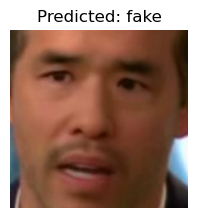

In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Bidirectional, LSTM, Reshape
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import cv2
import face_recognition
import os


def preprocess_video(video_path, output_folder):
    # Load the video
    video_capture = cv2.VideoCapture(video_path)

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Counter for extracted frames
    frame_counter = 0

    # Iterate over frames in the video
    while frame_counter < 5:
        # Read the next frame
        ret, frame = video_capture.read()

        # Check if the frame was successfully read
        if not ret:
            break

        # Find all face locations in the current frame
        face_locations = face_recognition.face_locations(frame)

        # Extract faces and save them as images
        for face_location in face_locations:
            top, right, bottom, left = face_location
            face_image = frame[top:bottom, left:right]

            # Resize the face image for consistency
            face_image = cv2.resize(face_image, (224, 224))

            # Save the face image to the output folder
            face_filename = os.path.join(
                output_folder, f"{os.path.basename(video_path)}_frame_{frame_counter}_face.jpg")
            cv2.imwrite(face_filename, face_image)

        # Increment frame counter
        frame_counter += 1

    # Release the video capture object
    video_capture.release()

    print("Face extraction completed.")

# Load the saved model
if __name__ == "__main__":
    
    preprocess_video(
        "id3_id9_0004.mp4", "Preprocess/real")
    
    model = tf.keras.models.load_model('video_model.h5')

    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        'Finalv3/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')


    test_generator = test_datagen.flow_from_directory(
        'Preprocess',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

    # Get class labels
    class_labels = list(train_generator.class_indices.keys())

    # Evaluate the model on the test data and get predictions
    test_generator.reset()  # Reset the generator to the beginning
    predictions = model.predict(test_generator)

    # Display the test dataset with predictions
    plt.figure(figsize=(10, 10))
    num_images = 1  # Number of images to display
    for i in range(num_images):
        # Get the next image and its label
        image, label = test_generator.next()
        # Make predictions
        prediction = predictions[i][0]
        predicted_label = class_labels[int(round(prediction))]

        # Display the image with its true and predicted labels
        plt.subplot(5, 5, i + 1)
        plt.imshow(image[0])
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    files = os.listdir("Preprocess/real")

    # Delete each file in the output folder
    for file in files:
        file_path = os.path.join("Preprocess/real", file)
        os.remove(file_path)

In [23]:
import moviepy.editor as mp


def video_to_audio(video_path, audio_path):
    # Load the video file
    clip = mp.VideoFileClip(video_path)

    # Extract the audio from the video
    clip.audio.write_audiofile(audio_path, codec='pcm_s16le')

    print("Audio extracted successfully.")


# Example usage
video_path = "video_real.mp4"  # Path to the input video file
audio_path = "output_audio.wav"  # Path to save the output audio file
video_to_audio(video_path, audio_path)

MoviePy - Writing audio in output_audio.wav


MoviePy - Done.
Audio extracted successfully.


In [26]:
import os
import librosa
from tensorflow.keras.models import load_model
import numpy as np


def extract_mfcc(audio_path, duration=2.0, num_mfcc=25, n_fft=2048, hop_length=512):
    # Load audio file with original sampling rate
    audio, sr = librosa.load(audio_path, sr=None)

    # Trim or pad the audio to the desired duration
    target_length = int(duration * sr)
    if len(audio) < target_length:
        # Pad audio if it's shorter than the target duration
        audio = np.pad(audio, (0, target_length - len(audio)), 'constant')
    else:
        # Trim audio if it's longer than the target duration
        audio = audio[:target_length]

    # Extract MFCC features
    mfccs = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

    # Ensure the number of frames matches the expected shape (173 frames)
    if mfccs.shape[1] < 173:
        # Pad MFCC features if there are fewer frames
        mfccs = np.pad(
            mfccs, ((0, 0), (0, 173 - mfccs.shape[1])), mode='constant')
    else:
        # Trim MFCC features if there are more frames
        mfccs = mfccs[:, :173]

    return mfccs


def preprocess_audio_file(input_audio_path, output_dir, duration=2.0):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Extract MFCC features
    mfccs = extract_mfcc(input_audio_path, duration=duration)

    # Save MFCC features to file
    output_file_path = os.path.join(output_dir, os.path.basename(
        input_audio_path).replace('.wav', '.npy'))
    np.save(output_file_path, mfccs)


def load_preprocessed_audio(audio_file_path):
    # Load and preprocess the audio file
    # You can implement your own audio preprocessing steps here
    # For example, you can use librosa to load the audio and extract features
    # Replace this with your own preprocessing code
    # Example:
    preprocess_audio_file(audio_file_path, "Preprocessed_audio", duration=2.0)
    audio_data = np.load("Preprocessed_audio/output_audio.npy")
    return audio_data


def predict_audio_deepfake(audio_data):
    # Load the trained model
    loaded_model = load_model("audio_model.h5")

    # Reshape the input data to match the expected shape of the model
    audio_data = audio_data.reshape(-1, 25, 173, 1)

    # Predict on the audio data
    prediction = loaded_model.predict(audio_data)

    # Convert prediction to binary label
    predicted_label = np.round(prediction).astype(int)[0]
    # Get class labels
    class_labels = ["Real", "Fake"]
    predicted_label_text = class_labels[predicted_label[0]]

    return predicted_label_text


# Example usage
input_audio_path = "output_audio.wav"  # Path to the audio file
audio_data = load_preprocessed_audio(input_audio_path)
predicted_label = predict_audio_deepfake(audio_data)
print(f"Predicted Label: {predicted_label}")

1/1 [==============================] - 1s 1s/step
Predicted Label: Real


: 

Face extraction completed.
Found 11590 images belonging to 2 classes.
Found 5 images belonging to 1 classes.
1/1 [==============================] - 0s 159ms/step


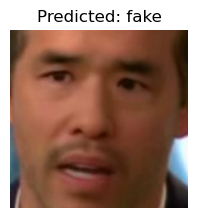

The Uploaded File is fake!


In [2]:
import os
import cv2
import face_recognition
import matplotlib.pyplot as plt
import numpy as np
import librosa
import moviepy.editor as mp
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

# Function to preprocess video for deepfake detection


def preprocess_video(video_path, output_folder):
    video_capture = cv2.VideoCapture(video_path)

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    frame_counter = 0

    while frame_counter < 5:
        ret, frame = video_capture.read()

        if not ret:
            break

        face_locations = face_recognition.face_locations(frame)

        for face_location in face_locations:
            top, right, bottom, left = face_location
            face_image = frame[top:bottom, left:right]
            face_image = cv2.resize(face_image, (224, 224))

            face_filename = os.path.join(
                output_folder, f"{os.path.basename(video_path)}_frame_{frame_counter}_face.jpg")
            cv2.imwrite(face_filename, face_image)

        frame_counter += 1

    video_capture.release()
    print("Face extraction completed.")


# Function to convert video to audio
def video_to_audio(video_path, audio_path):
    clip = mp.VideoFileClip(video_path)
    clip.audio.write_audiofile(audio_path, codec='pcm_s16le')
    print("Audio extracted successfully.")


# Function to extract MFCC features from audio file
def extract_mfcc(audio_path, duration=2.0, num_mfcc=25, n_fft=2048, hop_length=512):
    audio, sr = librosa.load(audio_path, sr=None)

    target_length = int(duration * sr)
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)), 'constant')
    else:
        audio = audio[:target_length]

    mfccs = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

    if mfccs.shape[1] < 173:
        mfccs = np.pad(
            mfccs, ((0, 0), (0, 173 - mfccs.shape[1])), mode='constant')
    else:
        mfccs = mfccs[:, :173]

    return mfccs


# Function to preprocess audio file
def preprocess_audio_file(input_audio_path, output_dir, duration=2.0):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    mfccs = extract_mfcc(input_audio_path, duration=duration)

    output_file_path = os.path.join(output_dir, os.path.basename(
        input_audio_path).replace('.wav', '.npy'))
    np.save(output_file_path, mfccs)


# Function to load preprocessed audio
def load_preprocessed_audio(audio_file_path):
    preprocess_audio_file(audio_file_path, "Preprocessed_audio", duration=2.0)
    audio_data = np.load("Preprocessed_audio/output_audio.npy")
    return audio_data


# Function to predict audio deepfake
def predict_audio_deepfake(audio_data):
    loaded_model = load_model("audio_model.h5")
    audio_data = audio_data.reshape(-1, 25, 173, 1)
    prediction = loaded_model.predict(audio_data)
    predicted_label = np.round(prediction).astype(int)[0]
    class_labels = ["real", "fake"]
    predicted_label_text = class_labels[predicted_label[0]]
    return predicted_label_text


# Function to predict video deepfake
def predict_video_deepfake():
    model = tf.keras.models.load_model('video_model.h5')

    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        'Finalv3/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

    test_generator = test_datagen.flow_from_directory(
        'Preprocess',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

    class_labels = list(train_generator.class_indices.keys())

    test_generator.reset()
    predictions = model.predict(test_generator)

    plt.figure(figsize=(10, 10))
    num_images = 1
    for i in range(num_images):
        image, label = test_generator.next()
        prediction = predictions[i][0]
        predicted_label = class_labels[int(round(prediction))]

        plt.subplot(5, 5, i + 1)
        plt.imshow(image[0])
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    files = os.listdir("Preprocess/real")

    for file in files:
        file_path = os.path.join("Preprocess/real", file)
        os.remove(file_path)
        
    result = predicted_label
    return predicted_label



def multimodal_deepfake_detection(video_path, audio_path):
    preprocess_video(video_path, "Preprocess/real")

    # Check if the video has an audio track
    clip = mp.VideoFileClip(video_path)
    has_audio = clip.audio is not None
    clip.close()

    if has_audio:
        video_to_audio(video_path, audio_path)
        video_label = predict_video_deepfake()
        audio_data = load_preprocessed_audio(audio_path)
        audio_label = predict_audio_deepfake(audio_data)
        return video_label, audio_label
    else:
        video_label = predict_video_deepfake()
        return video_label, None



# Example usage
video_path = "id3_id9_0004.mp4"
audio_path = "output_audio.wav"
video_label, audio_label = multimodal_deepfake_detection(
    video_path, audio_path)
if audio_label != None:
    if video_label == "real" and audio_label == "real":
        print("The Uploaded File is Real!")  # Pass it to frontend via props
    else:
        print("The Uploaded File is Fake!")
else:
    print("The Uploaded File is "+video_label+"!")